In [87]:
import random
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers
from keras.models import Model
from keras import backend as K
from keras.preprocessing.image import DirectoryIterator
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import Adam
from sklearn.metrics import classification_report
%matplotlib inline

## The Data

In [68]:
os.getcwd()

'/efs/home/felicia_heng/fh_image_analysis/painterByNumbers'

In [71]:
train_dir = 'gc_data/gc_data/train'
test_dir = 'gc_data/gc_data/test'

In [76]:
def image_preview(img_path, num=12, ncol=4):
    img_files = os.listdir(img_path)
    random.shuffle(img_files)
    img_files = img_files[:num]
    nrow = int(np.ceil(num/ncol))
    fig, axs = plt.subplots(nrow, ncol, figsize=(16, 8))
    fig.figure
    axs = axs.flatten()
    for i, file in enumerate(img_files):
        img = plt.imread(os.path.join(img_path,file))
        axs[i].imshow(img)

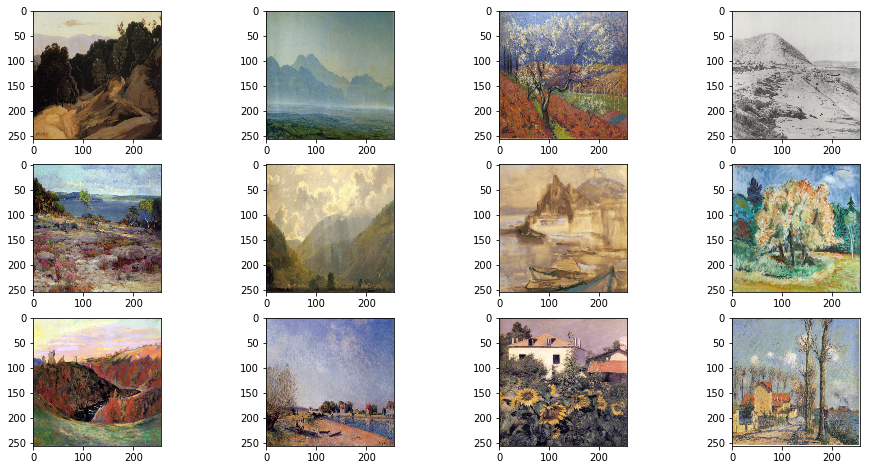

In [77]:
image_preview('gc_data/gc_data/test/landscape')

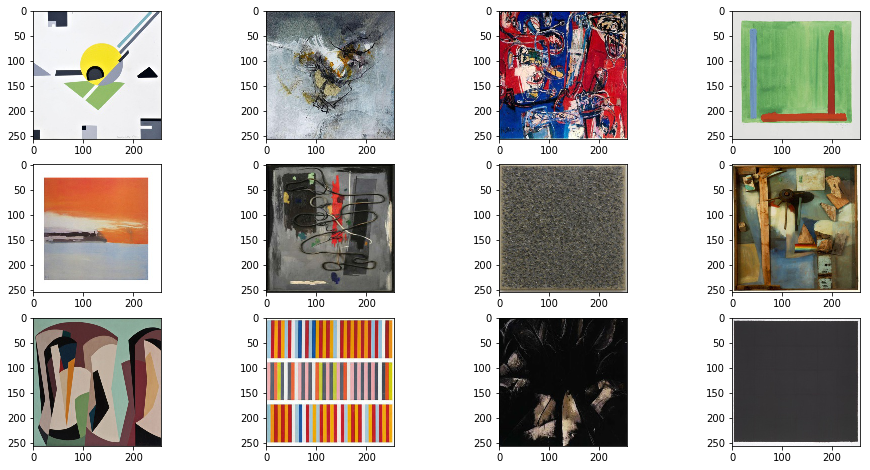

In [78]:
image_preview('gc_data/gc_data/test/abstract')

## Keras Data Generator

In [79]:


# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(128, 128),  # All images will be resized to 150x150
        batch_size=32,
        color_mode = 'rgb',
        class_mode='categorical')

# Flow validation images in batches of 20 using test_datagen generator
# https://keras.io/preprocessing/image/
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(128, 128),
        batch_size=32,
        color_mode = 'rgb',
        class_mode='categorical')

print(test_generator.class_indices)

Found 38451 images belonging to 23 classes.
Found 7389 images belonging to 23 classes.
{'abstract': 0, 'advertisement': 1, 'bijinga': 2, 'calligraphy': 3, 'capriccio': 4, 'caricature': 5, 'cityscape': 6, 'cloudscape': 7, 'design': 8, 'figurative': 9, 'illustration': 10, 'interior': 11, 'landscape': 12, 'marina': 13, 'miniature': 14, 'panorama': 15, 'pastorale': 16, 'portrait': 17, 'poster': 18, 'quadratura': 19, 'tessellation': 20, 'vanitas': 21, 'veduta': 22}


## The Model

In [80]:
# Configure the TF backend session
tf_config = tf.ConfigProto(
    gpu_options=tf.GPUOptions(allow_growth=True))
K.set_session(tf.Session(config=tf_config))

In [81]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [82]:
# input image shape 128x128x3
image_input = layers.Input(shape=(128, 128, 3))

# ConNet layer of 3x3x16
x = layers.Conv2D(16, 3, activation='relu')(image_input)
# Pooling layer of 2x2
x = layers.MaxPooling2D(2)(x)

# ConNet layer of 3x3x32
x = layers.Conv2D(32, 3, activation='relu')(x)
# Pooling layer of 2x2
x = layers.MaxPooling2D(2)(x)

# ConNet layer of 3x3x64
x = layers.Conv2D(64, 3, activation='relu')(x)
# Pooling layer of 2x2
x = layers.MaxPooling2D(2)(x)

# Flatten the final layer
x = layers.Flatten()(x)
# Create a fully connected layer with ReLU activation and 512 hidden units
#
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.2)(x)

output = layers.Dense(23, activation='softmax')(x)

# create model
model = Model(image_input, output)

In [83]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['acc', f1])


### Add class weights to overcome unbalanced labels

In [102]:
def label_weights(label_dict):
    label_weights = {}
    for key, value in label_dict.items():
        label_weights[key] = sum(label_dict.values())/(value*len(label_dict))
    return label_weights                                                  
                                                       
def get_class_weight(train_generator):
    class_indx = train_generator.class_indices
    df = pd.DataFrame([file.split('/') for file in train_generator.filenames], columns=['class', 'filename'])
    label_dict = df.groupby('class').count().to_dict()['filename']
    print(label_dict)
    for key, value in class_indx.items():
        label_dict[value] = label_dict[key]
        del label_dict[key]
    return(label_weights(label_dict))

In [103]:
class_weights = get_class_weight(train_generator)

{'abstract': 6155, 'advertisement': 55, 'bijinga': 71, 'calligraphy': 100, 'capriccio': 159, 'caricature': 145, 'cityscape': 3479, 'cloudscape': 131, 'design': 1335, 'figurative': 1529, 'illustration': 2111, 'interior': 448, 'landscape': 9868, 'marina': 1176, 'miniature': 91, 'panorama': 14, 'pastorale': 80, 'portrait': 11022, 'poster': 194, 'quadratura': 11, 'tessellation': 123, 'vanitas': 23, 'veduta': 131}


In [104]:
print(class_weights)

{0: 0.27161374633560553, 1: 30.39604743083004, 2: 23.546233925290874, 3: 16.71782608695652, 4: 10.514356029532404, 5: 11.529535232383807, 6: 0.480535386230426, 7: 12.761699303020245, 8: 1.2522716170004886, 9: 1.0933830011089942, 10: 0.7919387061561592, 11: 3.7316576086956523, 12: 0.16941453270122134, 13: 1.421583850931677, 14: 18.37123745819398, 15: 119.41304347826087, 16: 20.89728260869565, 17: 0.15167688338737545, 18: 8.617436127297177, 19: 151.9802371541502, 20: 13.591728525980912, 21: 72.68620037807183, 22: 12.761699303020245}


In [ ]:
batch_size = 20

paints = model.fit_generator(
      train_generator,
      steps_per_epoch= 38451 // batch_size,  # 38451 images = batch_size * steps
      epochs=20,
      validation_data=test_generator,
      validation_steps= 7389 // batch_size,  # 7389 images = batch_size * steps
      verbose=2,
      class_weight=class_weights)

Epoch 1/20


## Model Performance on Test Data

In [106]:
target_names=train_generator.class_indices.keys()
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v

In [107]:
from sklearn.metrics import classification_report
y_pred = model.predict_generator(test_generator, test_generator.n/test_generator.batch_size)
print(y_pred.shape)
y_pred = np.argmax(y_pred, axis=-1) #multiple categories
y_test = test_generator.classes # Convert one-hot to index
print(classification_report(y_test, y_pred))

(7389, 23)
             precision    recall  f1-score   support

          0       0.17      0.17      0.17      1206
          1       0.00      0.00      0.00        10
          2       0.00      0.00      0.00        19
          3       0.00      0.00      0.00        27
          4       0.00      0.00      0.00        32
          5       0.00      0.00      0.00        19
          6       0.10      0.10      0.10       687
          7       0.00      0.00      0.00        33
          8       0.04      0.04      0.04       268
          9       0.06      0.06      0.06       284
         10       0.03      0.03      0.03       347
         11       0.01      0.01      0.01        79
         12       0.26      0.25      0.25      1885
         13       0.03      0.04      0.04       236
         14       0.00      0.00      0.00        19
         15       0.00      0.00      0.00         3
         16       0.00      0.00      0.00        10
         17       0.28      0.28  

### Visualization to compare true and false labels.

In [110]:
# index of misclassified images
indices = [i for i,v in enumerate(y_pred) if y_pred[i]!=y_test[i]]

In [117]:
sample_idx = random.choice(indices)
sample_file = test_generator.filenames[sample_idx]
print('True label: ', label_map[y_test[sample_idx]])
print('Predicted label: ', label_map[y_pred[sample_idx]])

True label:  landscape
Predicted label:  portrait


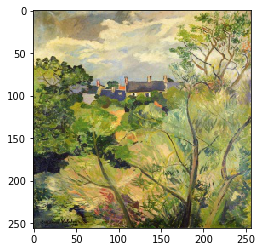

In [118]:
img = plt.imread(test_dir + '/' + sample_file)
plt.imshow(img)

In [ ]:
paints.history.keys()

Text(0.5,1,'Training and validation loss')

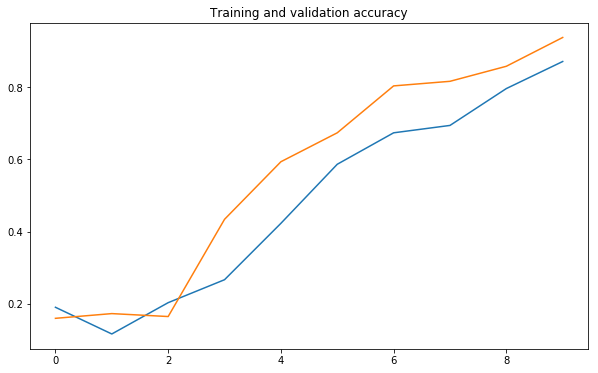

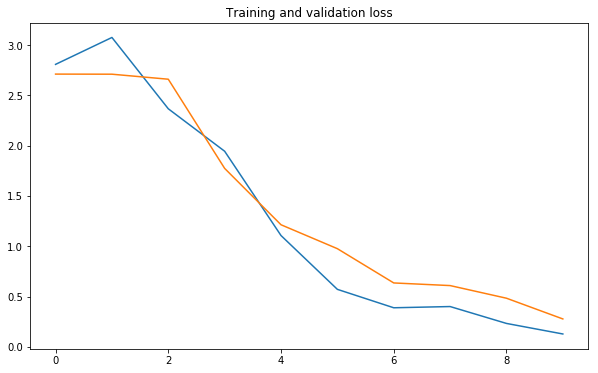

In [122]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = paints.history['acc']
val_acc = paints.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = paints.history['loss']
val_loss = paints.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.figure(figsize=(10,6))
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure(figsize=(10,6))
# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

## Visualizing Intermediate Representations

In [126]:
image_input

<tf.Tensor 'input_4:0' shape=(?, 128, 128, 3) dtype=float32>

In [127]:
import numpy as np
import random
from keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model.
successive_outputs = [layer.output for layer in model.layers]
visualization_model = Model(image_input, successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
# cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
# dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]
# img_path = random.choice(cat_img_files + dog_img_files)

img = load_img('test_pblue.jpg', target_size=(128, 128))  # this is a PIL image # 2438.jpg, 1478.jpg, 398.jpg
x = img_to_array(img)  # Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 3, 150, 150)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]


In [128]:
for f in successive_feature_maps:
    print(f.shape)

(1, 128, 128, 3)
(1, 126, 126, 16)
(1, 63, 63, 16)
(1, 61, 61, 32)
(1, 30, 30, 32)
(1, 28, 28, 64)
(1, 14, 14, 64)
(1, 12544)
(1, 512)
(1, 512)
(1, 23)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


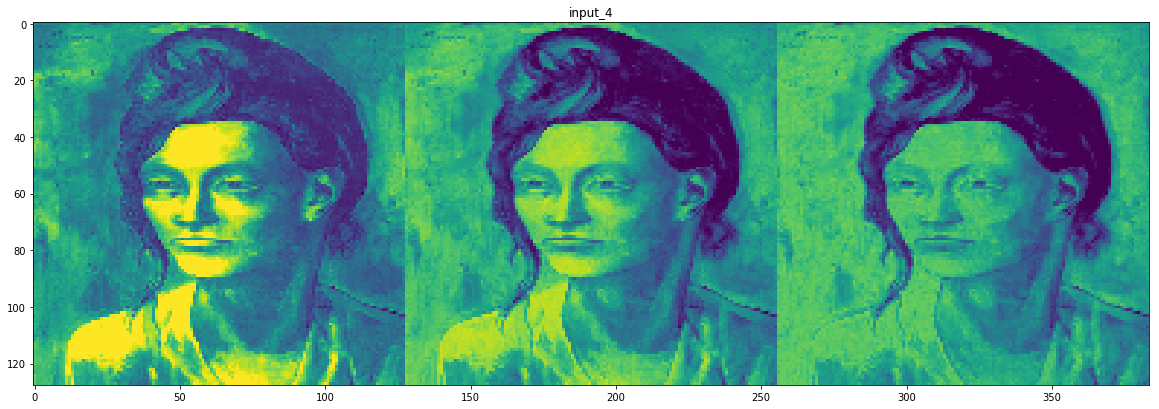

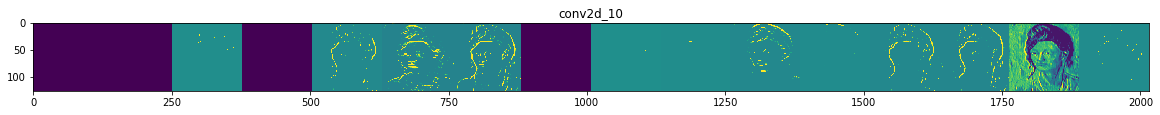

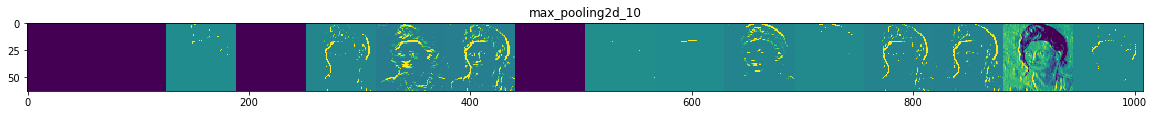

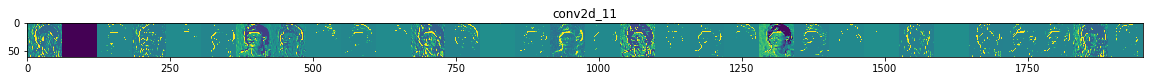

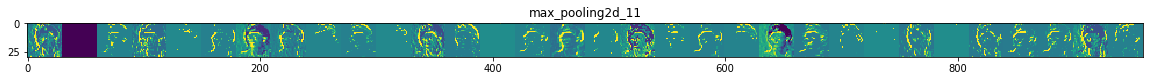

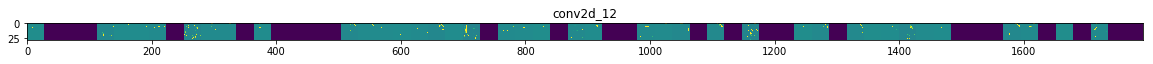

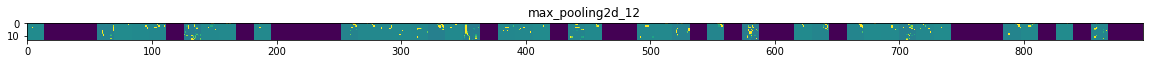

In [129]:
import matplotlib.pyplot as plt
# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')